# NICE para calibración multiclase

Este notebook presenta un resumen del trabajo realizado hasta el momento (septiembre 2019). El objetivo es un estudio sobre el uso de NICE, un *normalizing-flow*, como método de calibración.

El notebook se organiza en los siguientes puntos principales:
* **Calibracion**
    * Enfoque Intuitivo.
    * Enfoque Teoría de la información.
* **Clasificación en 3 categorías.**
    * Gráficos ternarios.
    * Efecto de métodos de calibración.
    * CIFAR3.
* **NICE**
    * NICE en 3 dimensiones: efecto en el 2-símplex.
    * NICE como método de calibración para clasificadores.
    * NICE como calibración óptima en multiclase.




In [1]:
import os
import sys
import time
import random
import itertools
sys.path.append('..')

import ternary
from ternary import scatter
import numpy as np
import tensorflow as tf
from scipy.special import softmax
import matplotlib.pyplot as plt

from utils.data import get_cifar10, get_cifar3, load_logits
from utils.ops import onehot_encode, optim_temperature
from utils.metrics import neg_log_likelihood, expected_calibration_error
from utils.visualization import plot_pdf_simplex, plot_prob_simplex, reliability_diagram, plot_cal_regions_ternary
from calibrators import NiceCalibrator, TempScalingCalibrator

## Calibración:

La calibración puede entenderse desde 2 puntos de vista distintos, uno más intuitivo basado en la coherencia entre los valores de probabilidad dados por el clasificador y su porcentaje de exito, y otro basado en teoría de la información.

### Enfoque intuitivo:

Se define la calibración como 

## Clasificación en 3 categorías:

Gran parte de los experimentos se han llevado a cabo en problemas de clasificación en 3 clases, el mínimo para ser considerado multiclase y la versión más simple del problema. Esta configuración tiene la ventaja añadida de tener una facil visualización de la distribución de probabilidad, que esta contenida en el 2-símplex estándar, permitiendo la representación en el plano. Apoyandonos en estos gráficos, podemos observar el efecto de las técnicas de calibración estado del arte como *temp-scaling*, señalando el por qué es necesario el uso de un método de calibración mas expresivo.

### Gráficos ternarios:

O *ternary plots*, son un tipo de diagramas que se emplean para representar 3 variables que suman una constante. El diagrama consiste en un triangulo equilatero en el que las variables se pintan como puntos dentro del triangulo, cada vértice corresponde con el punto de valor máximo (la constante) que puede tomar cada variable, disminuyendo su valor en la dirección de la bisectriz que corta dicho vertice. Este tipo de gráficos resulta muy util para representar probabilidades. Por ejemplo:

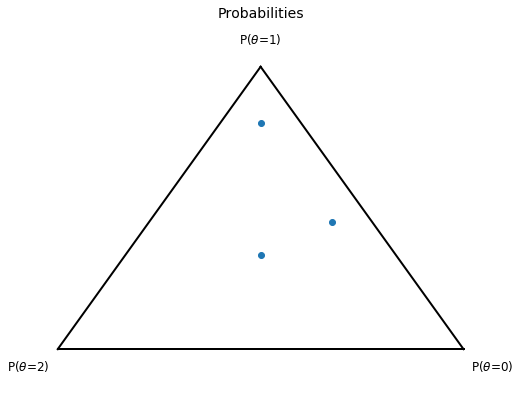

In [2]:
probs = np.array([[1/3., 1/3., 1/3.],
                  [0.45, 0.45, 0.1],
                  [0.1, 0.8, 0.1]])

fig, ax = plt.subplots(figsize=(8, 6))

ax = plot_prob_simplex(probs, ax=ax)

plt.show();

### Métodos de calibración en el 2-símplex:

Para visualizar el efecto que tienen las distintas técnicas las aplicamos a probabilides de salida de un clasificador simuladas.

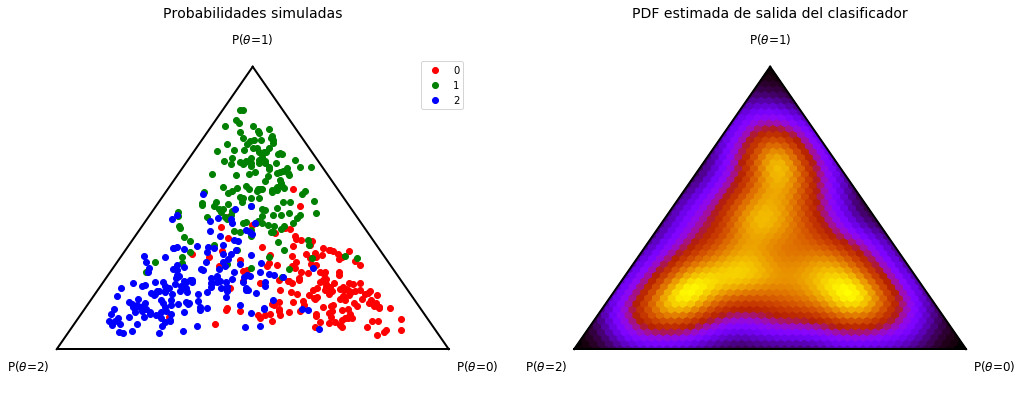

In [4]:
# Numero de muestras
n_samples = 500

# Distribucion objetivo o groundtruth
target = np.array(random.choices(range(3), k=n_samples))
one_hot = onehot_encode(target)

# Logits y porbabilidades simulados
logits = one_hot+np.random.randn(n_samples, 3)*0.5
probs = softmax(logits, axis=1)

# Visualizamos las probabilidades
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6))
ax_arr[0] = plot_prob_simplex(probs, target=target, ax=ax_arr[0], title='Probabilidades simuladas', fontsize=12);
ax_arr[1] = plot_pdf_simplex(probs, ax=ax_arr[1], title='PDF estimada de salida del clasificador', fontsize=12);
plt.show()

#### Temp-scaling:
El escalado por temperatura o *temperature scaling* es un método de calibración muy sencillo que consiste en escalar los *logits* del clasificador dividiendo entre un factor de temperatura, $T$. El vector de probabilidades  se calcula como:
$$
\vec{\theta} = softmax\left(\frac{\vec{\lambda}}{T}\right),
$$

Donde $\vec{\lambda}$ es el vector de logits de salida del clasificador. Para obtener la mejor calibración posible se optimiza la función de coste Negative Log-likelihood con respecto a $T$ sobre un conjunto de validación.

Podemos observar el efecto que tiene el factor $T$ sobre la distribución de probabilidades de salida:

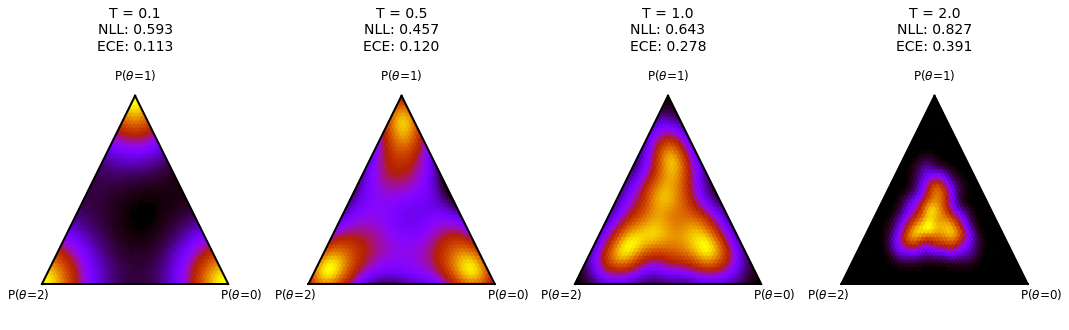

In [5]:
Ts = [0.1, 0.5, 1., 2.]

fig, ax_arr = plt.subplots(1, 4, figsize=(18, 4), gridspec_kw={'wspace': 0.3})
for i, T in enumerate(Ts):
    cal_probs = softmax(logits/T, axis=1)
    nll = neg_log_likelihood(cal_probs, target)
    ece = expected_calibration_error(cal_probs, target)
    ax_arr[i] = plot_pdf_simplex(cal_probs, ax=ax_arr[i], title='T = {:.1f}\nNLL: {:.3f}\nECE: {:.3f}'.format(T, nll, ece))
    
plt.show();

Calculando la temperatura óptima:

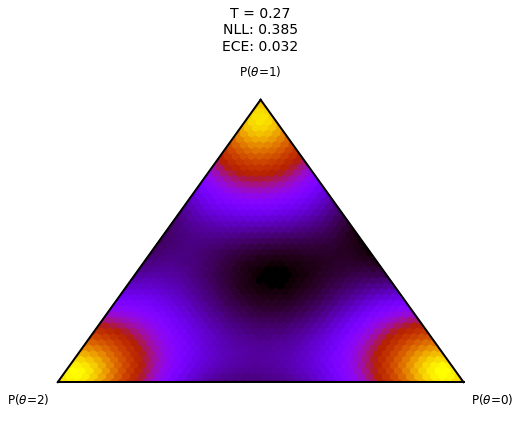

In [8]:
T = optim_temperature(logits, target)

fig, ax = plt.subplots(figsize=(8, 6))

cal_probs = softmax(logits/T, axis=1)
nll = neg_log_likelihood(cal_probs, target)
ece = expected_calibration_error(cal_probs, target)
ax = plot_pdf_simplex(cal_probs, ax=ax, title='T = {:.2f}\nNLL: {:.3f}\nECE: {:.3f}'.format(T, nll, ece))

plt.show();

En este caso temp-scaling para funcionar bien, mejorando mucho las métricas utilizadas para evaluar la calibración. Como vemos su efecto no es más que el de acercar o alejar las probabilidades a sus valores extremos. Por ejemplo, para una probabilidad sin calibrar igual a (0.2, 0.3, 0.5), un valor infinitamente alto de temperatura resultaría en una distribución uniforme, (0.33, 0.33, 0.33) en este caso, mientras que un valor infinitamente pequeño daría probabilidades extremas, (0.0, 0.0, 1.0).

Esto funciona bien mientras las probabilidades de salida esten bien alineadas con los respectivos ejes baricéntricos correspondientes a su categoría real. Sin embargo, un clasificador mal calibrado podría tener una capacidad de discriminación muy buena pero con las probabilidades desviadas de estos ejes, en este caso no podemos esperar que temp scaling funcione bien.

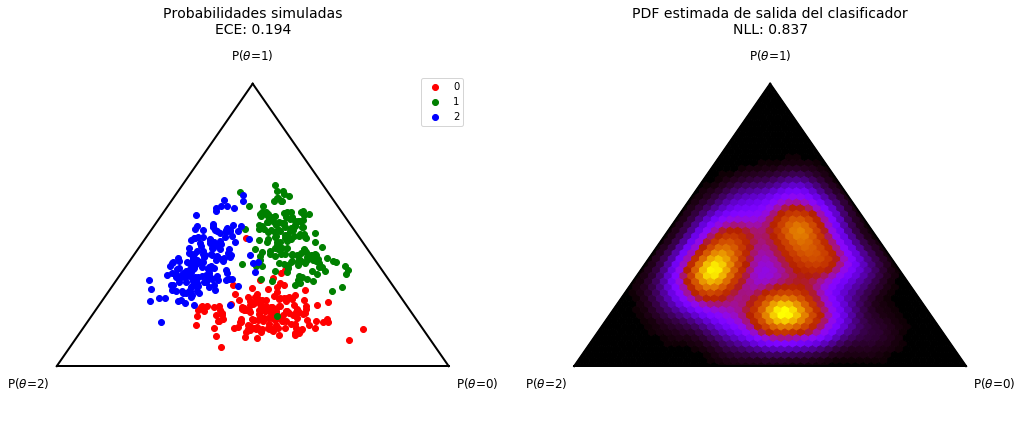

In [15]:
# Clasificador desviado
twisting = np.zeros((n_samples, 3))
twisting[np.arange(n_samples), target-1] = 0.8 + np.random.randn(n_samples)*0.2

logits = 0.9 * (one_hot + twisting + np.random.randn(n_samples, 3)*0.3)
probs = softmax(logits, axis=1)
nll = neg_log_likelihood(probs, target)
ece = expected_calibration_error(probs, target)

fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6))
ax_arr[0] = plot_prob_simplex(probs, target=target, ax=ax_arr[0], title='Probabilidades simuladas\nECE: {:.3f}'.format(ece), fontsize=12);
ax_arr[1] = plot_pdf_simplex(probs, ax=ax_arr[1], title='PDF estimada de salida del clasificador\nNLL: {:.3f}'.format(nll), fontsize=12);
plt.show()

Aplicando Temp-Scaling:

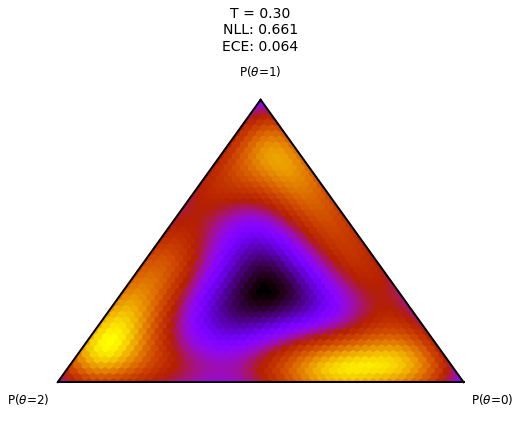

In [14]:
T = optim_temperature(logits, target)

fig, ax = plt.subplots(figsize=(8, 6))

cal_probs = softmax(logits/T, axis=1)
nll = neg_log_likelihood(cal_probs, target)
ece = expected_calibration_error(cal_probs, target)
ax = plot_pdf_simplex(cal_probs, ax=ax, title='T = {:.2f}\nNLL: {:.3f}\nECE: {:.3f}'.format(T, nll, ece))

plt.show();

Aunque la calibración mejora, queda claro que un método de calibración más expresivo funcionaría mejor. En este ejemplo podemos reconocer facilmente una transformación invertible que resultase en una distribución más cercana a la objetivo.

### CIFAR3:

Además de trabajar sobre distribuciones simuladas que nos permiten visualizar algunas ideas muy bien, tambien es conveniente poder analizar el comportamiento de clasificadores reales. Para no perder la ventaja de la representabilidad y seguir trabajando con un problema relativamente sencillo se ha creado CIFAR3 un dataset de imagenes generado a partir de CIFAR10 en el que solo están presentes las 3 primeras clases: automóvil, pájaro, y avión.

In [17]:
cifar_dir = '../cifar-10'
cifar3, ix2label = get_cifar3(cifar_dir, test=True)

Algunas imágenes:

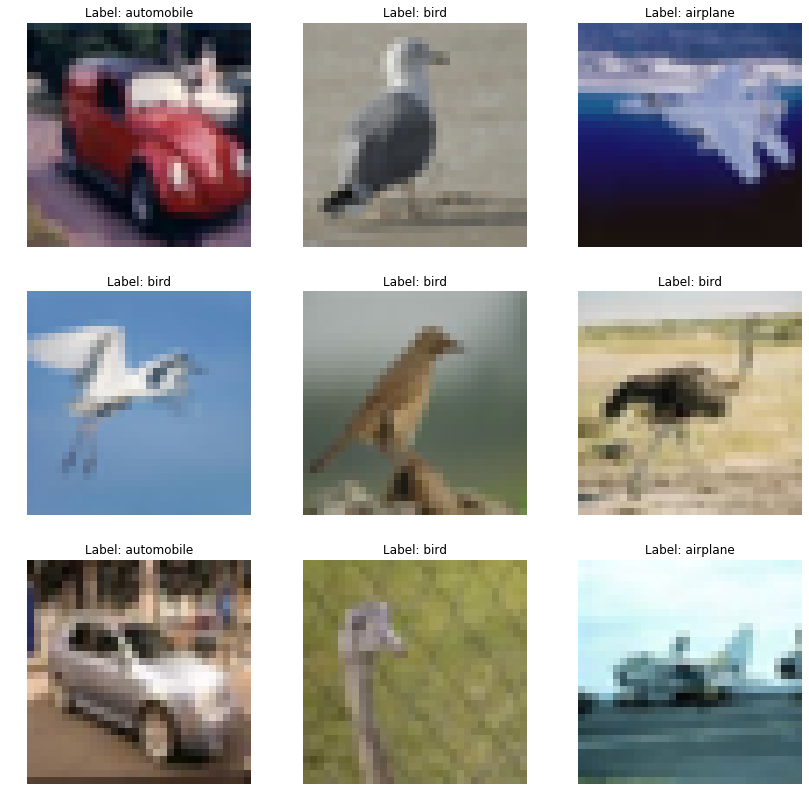

In [20]:
imas = random.sample(range(len(cifar3['images'])), k=9)

fig, ax_arr = plt.subplots(3, 3, figsize=(14, 14))

for i, ima in enumerate(imas):
    ax_arr[i//3, i%3].imshow(cifar3['images'][ima])
    ax_arr[i//3, i%3].set_title('Label: {}'.format(ix2label[cifar3['labels'][ima]]))
    ax_arr[i//3, i%3].axis('off')

## NICE: Non-linear Independent Components Estimation

NICE es un normalizing-flow basado en redes neuronales. Un normalizing flow consiste en la aplicación sucesiva de una serie de transformaciones invertibles sobre una variable aleatoria. La composición de dos o más transformaciones invertibles resulta en una transformación invertible, permitiendo el uso de normalizing-flows como algoritmos de calibración. Entre otras, Nice propone el uso de *additive coupling layers*, transformaciones invertible sobre variable aleatoria $X$ que permiten aplicar cualquier función, invertible o no.
Sea $I_1, I_2$ una partición de $[1, D]$, donde $D$ es el número de dimensiones de $X$, $|I_1| = d$, y $|I_2| = D-d$, la transformación queda definida como:
$$
Y = (Y_{I_1}, Y_{I_2}), \\
Y_{I_1} = X_{I_1}, \\
Y_{I_2} = X_{I_2} + h(X_{I_1}),
$$

Donde $h: \mathbb{R}^{d}\mapsto \mathbb{R}^{D-d}$ es una función cualquiera, como una red neuronal. La transformación inversa esta definida por:
$$
X = (X_{I_1}, X_{I_2}), \\
X_{I_1} = Y_{I_1}, \\
X_{I_2} = Y_{I_2} - h(Y_{I_1}),
$$

La configuración propuesta en el paper es una aplicación sucesiva de estas transformaciones en las que $I_1, I_2$ dividen el espacio de dimensiones en pares e impares alternativativamente, de tal manera que en una capa $I_1$ representa las dimensiones pares y en la siguiente las impares. $h$ se implementa con un perceptron multicapa que usa *ReLU* como función de activación.

### Efecto de NICE en el ejemplo anterior:

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


C:\Users\sergi\Anaconda3\envs\famarch\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Fitted in 28.944s


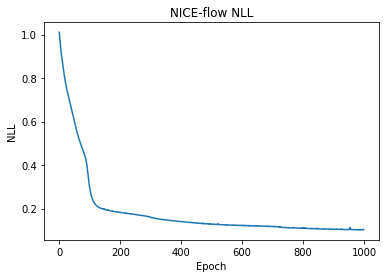

In [21]:
t0 = time.time()
nice_cal = NiceCalibrator(logits, target, layers=4, hidden_size=[4, 4])
print('Fitted in {:.3f}s'.format(time.time()-t0))

# Plot training NLL
plt.plot(nice_cal.history.history['loss'])
plt.title('NICE-flow NLL')
plt.ylabel('NLL')
plt.xlabel('Epoch')
plt.show()

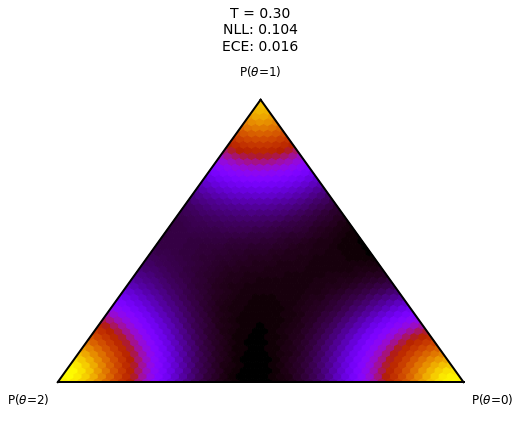

In [22]:
cal_probs = nice_cal(logits)
nll = neg_log_likelihood(cal_probs, target)
ece = expected_calibration_error(cal_probs, target)

fig, ax = plt.subplots(figsize=(8, 6))
ax = plot_pdf_simplex(cal_probs, ax=ax, title='NLL: {:.3f}\nECE: {:.3f}'.format(T, nll, ece))
plt.show();

### NICE como método de calibración:
La aplicación práctica de algoritmos como temp-scaling suele ser la de calibrar clasificadores para su posterior uso en nuevos conjuntos de datos. Para ello, el clasificador se calibra en un conjunto de validación que contiene una distribución lo más parecida posible a la distribución que se encontrará en su aplicación real. Por ello no es solo importante conseguir una buena calibración en un conjunto de validación sino que además esta se mantenga en el nuevo conjunto. Para evaluar esta capacidad los experimentos se han llevado a cabo de la siguiente forma. Se han entrenado redes neuronales en los conjuntos de entrenamiento de CIFAR3 y CIFAR10, despues los métodos de calibración se han ajustado en un conjunto de validación, para terminar la calibración se ha medido en un tercer conjunto de test.

Como puede verse en las figuras incluidas, NICE no es capaz de conservar una buena capacidad de calibración al extenderse al conjunto de test. Esto puede explicarse por el hecho de que es una transformación demasiado expresiva y que no tiene en cuenta la incertidumbre. Una posible solución sería tomar un enfoque más bayesiano del problema.

![nice-cifar3-calibration](../images/nice-calibration-validity-cifar3.png)

El efecto se acentúa cuando calibramos una red entrenada en CIFAR10, esto sugiere que la calibración es un problema cuya complejidad escala con la dimensionalidad. Cuantas más dimensiones más sobreajuste presenta NICE, un método de calibración muy expresivo.

![nice-cifar10-calibration](../images/nice-calibration-validity-cifar10.png)


### NICE como calibrador óptimo en multiclase:
En el caso de clasificación binaria, el problema de calibración óptima dado un conjunto de datos esta resuelto. Dado un conjunto de puntuaciones de salida de un clasificador, existe una transformación monotonamente creciente sobre estas que resulta en un conjunto probabilidades que minimizan una *proper scoring rule*. Esta transformación se obtiene aplicando el algoritmo PAV. La transformación es monotonamente creciente para asegurar que es invertible y que mantiene el sentido de las puntuaciones del clasificador, esto es, el clasificador asigna puntuaciones más altas cuando estima que la probabilidad es mayor.

Desafortunadamente, cuando extendemos la configuración a multiclase el problema se complica y no hay un algoritmo similar. Para empezar, ahora es más dificil interpretar el "sentido" de las puntuaciones del clasificador, con más de una dimensión el concepto de monotamente creciente ya no es aplicable. El objetivo es encontrar una transformación invertible que minimice una *proper scoring rule*, para ello ha de ser expresiva en el sentido de que a mayor dimensionalidad más compleja es la calibración.

Si bien NICE no parece adecuado como método de calibración para mejorar un algoritmo de clasificación por ser demasiado expresivo, si es capaz de encontrar una transformación que optimiza una *proper scoring rule* sobre un conjunto de datos mucho mejor que cualquier otro método de calibración. Obteniendo así una separación entre error de discriminación y error de calibración mucho más precisa.

![nice-cifar3-optimum-calibration](../images/nice-calibration-optimum-cifar3.png)

![nice-cifar10-optimum-calibration](../images/nice-calibration-optimum-cifar10.png)